In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..
%pwd

/home/markus/Documents/regression-prediction


'/home/markus/Documents/regression-prediction'

In [15]:
from experiments.data_utils import *
from experiments.plot_utils import *
from experiments.hyperparam_tuning import *

In [4]:
X, y, features = get_ml_data_traditional('bugbug', 'performance', 'commitlevel')

performance: 4062 positive 4.07% - negative 95632 95.93%
X.shape=(99694, 301)



In [5]:
features

,lines_added,lines_deleted,lines_modified,number_of_modified_files,number_of_subsystems,number_of_directories,entropy_lines_modified,comment_length,developer_age,developer_experience,...,min_delta_loc_lloc,min_delta_loc_cloc,min_delta_loc_blank,min_delta_nom_functions,min_delta_nom_closures,min_delta_nom_total,min_delta_mi_mi_original,min_delta_mi_mi_sei,min_delta_mi_mi_visual_studio,target
revision,,,,,,,,,,,,,,,,,,,,,
1582b3ffe71226af68979a58b5852afa49ff939b,55,13,68,0,2,2,1.422138,21,378751,832,...,2.0,0.0,1.0,0.0,0.0,0.0,-0.589408,-0.706975,0.000000,0
199bcb54e5122b5e7ac2476c90288b2169db2013,0,0,0,0,0,0,0.000000,12,114075,690,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
7d964bfcda0e0aded01a4fb05a8405b9cb61bafd,15,2,17,0,1,1,0.522559,11,114076,691,...,2.0,0.0,0.0,0.0,0.0,0.0,-3.968025,-7.528525,-2.320483,0
696aa5fa31ea5c39cee412a6cecfd4af19f845fd,8,6,14,0,1,2,0.749595,12,114077,692,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.172779,-0.330138,-0.101040,0
da65877c0fec3c21af44c542bada87ea8e8c6eea,13,9,22,0,1,1,0.000000,21,439301,2415,...,2.0,0.0,0.0,0.0,0.0,0.0,-0.025310,-0.052102,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2e03fdd340bda8085be8e6dc6e5277f09aa8a171,11,0,11,0,1,1,0.000000,55,110869,295,...,2.0,6.0,2.0,0.0,0.0,0.0,-0.627029,-0.335385,-0.366684,0
f398c3d4e21385a4b57ff67609fecca718a21416,1,1,2,0,1,1,0.000000,53,515072,1372,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.000616,-0.000889,0.000000,0
6e81bb1b5c7b19bff22b847d72d814cb1c7a63fa,0,0,0,0,0,0,0.000000,13,284398,206,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [6]:
feature_names = features.columns
feature_names

Index(['lines_added', 'lines_deleted', 'lines_modified',
       'number_of_modified_files', 'number_of_subsystems',
       'number_of_directories', 'entropy_lines_modified', 'comment_length',
       'developer_age', 'developer_experience',
       ...
       'min_delta_loc_lloc', 'min_delta_loc_cloc', 'min_delta_loc_blank',
       'min_delta_nom_functions', 'min_delta_nom_closures',
       'min_delta_nom_total', 'min_delta_mi_mi_original',
       'min_delta_mi_mi_sei', 'min_delta_mi_mi_visual_studio', 'target'],
      dtype='object', length=302)

In [7]:
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shap
import sklearn.metrics as metrics

/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [8]:
shap.initjs()

In [9]:
def plot_important_features(clf, X, feature_names):
    explainer = shap.TreeExplainer(clf)
    #explainer = shap.Explainer(clf)

    # print(explainer)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X, max_display=10, feature_names=feature_names)
    plt.show()

In [10]:
def ml_pipeline(X_train, X_test, y_train, y_test, feature_names, clf, plot_feature_importance=True):
    clf.fit(X_train, y_train)

    print("Train:")
    y_pred = clf.predict(X_train)
    report = metrics.classification_report(y_train, y_pred)
    print(report)
    if plot_feature_importance:
        plot_important_features(clf, X_train, feature_names)
    #ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred), display_labels=['no regr.', 'regr.']).plot()
    plt.show()

    print("Test:")
    y_pred = clf.predict(X_test)
    report = metrics.classification_report(y_test, y_pred)
    print(report)
    #plot_important_features(clf, X_test, feature_names)
    plot_precision_recall_curve_with_f1(clf, X_test, y_test)

    #ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=['no regr.', 'regr.']).plot()
    #plt.show()

In [11]:
def make_clf():
    clf = xgboost.XGBClassifier(
        n_jobs=4,
        use_label_encoder=False,
        eval_metric='logloss'
        )
    return clf

# def make_clf():
#     from sklearn.linear_model import LogisticRegression
#     clf = LogisticRegression()
#     return clf

Train:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     86100
           1       1.00      0.66      0.80      3624

    accuracy                           0.99     89724
   macro avg       0.99      0.83      0.90     89724
weighted avg       0.99      0.99      0.99     89724



ntree_limit is deprecated, use `iteration_range` or model slicing instead.


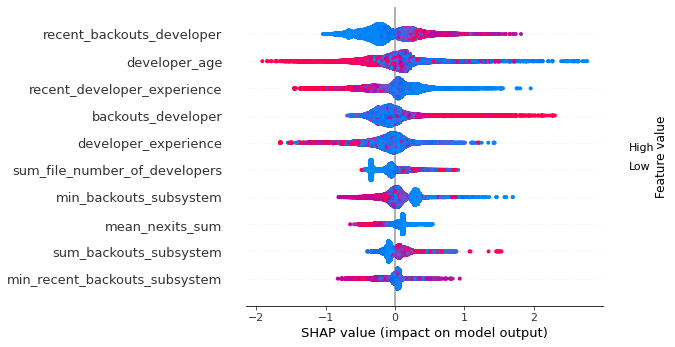

Test:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      9532
           1       0.94      0.38      0.54       438

    accuracy                           0.97      9970
   macro avg       0.96      0.69      0.77      9970
weighted avg       0.97      0.97      0.97      9970

best F1: 0.6666666666666666 at precision=0.7678571428571429 recall=0.589041095890411


invalid value encountered in true_divide


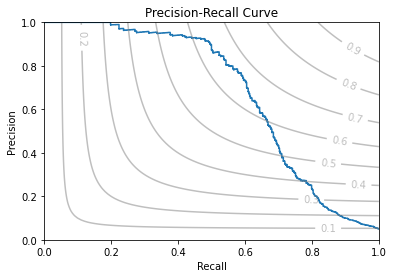

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, shuffle=True)
clf = make_clf()
ml_pipeline(X_train, X_test, y_train, y_test, feature_names, clf)

Train:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     86253
           1       1.00      0.68      0.81      3471

    accuracy                           0.99     89724
   macro avg       0.99      0.84      0.90     89724
weighted avg       0.99      0.99      0.99     89724



ntree_limit is deprecated, use `iteration_range` or model slicing instead.


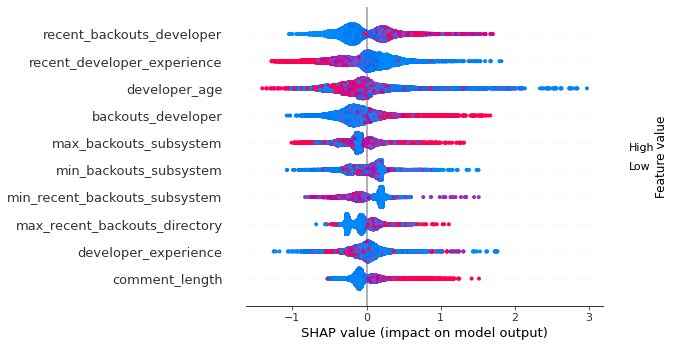

Test:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      9379
           1       0.07      0.01      0.01       591

    accuracy                           0.94      9970
   macro avg       0.51      0.50      0.49      9970
weighted avg       0.89      0.94      0.91      9970

best F1: 0.14017595307917888 at precision=0.08478183753103938 recall=0.40439932318104904


invalid value encountered in true_divide


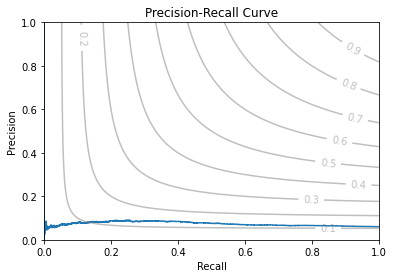

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, shuffle=False)
clf = make_clf()    
ml_pipeline(X_train, X_test, y_train, y_test, feature_names, clf)

In [14]:
# difference not as pronounced with Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, shuffle=True)
clf = default_pipeline()
clf.set_params(model=LogisticRegression(random_state=0, C=2), sampler=RandomOverSampler(random_state=0))

ml_pipeline(X_train, X_test, y_train, y_test, feature_names, clf, plot_feature_importance=False)

NameError: name 'default_pipeline' is not defined

## Why?

In [16]:
labeling = pd.read_csv('data/labeling/bugbug.csv')
labeling['index'] = labeling['revision']
labeling.set_index('index', inplace=True)
labeling

,revision,bug_id,regression,performance,crash,security,memory,power
index,,,,,,,,
1582b3ffe71226af68979a58b5852afa49ff939b,1582b3ffe71226af68979a58b5852afa49ff939b,1551601,1,0,0,0,0,0
199bcb54e5122b5e7ac2476c90288b2169db2013,199bcb54e5122b5e7ac2476c90288b2169db2013,1551738,1,0,0,0,0,0
7d964bfcda0e0aded01a4fb05a8405b9cb61bafd,7d964bfcda0e0aded01a4fb05a8405b9cb61bafd,1551738,1,0,0,0,0,0
696aa5fa31ea5c39cee412a6cecfd4af19f845fd,696aa5fa31ea5c39cee412a6cecfd4af19f845fd,1557190,0,0,0,0,0,0
da65877c0fec3c21af44c542bada87ea8e8c6eea,da65877c0fec3c21af44c542bada87ea8e8c6eea,1561858,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
2e03fdd340bda8085be8e6dc6e5277f09aa8a171,2e03fdd340bda8085be8e6dc6e5277f09aa8a171,1679741,0,0,0,0,0,0
f398c3d4e21385a4b57ff67609fecca718a21416,f398c3d4e21385a4b57ff67609fecca718a21416,1738400,0,0,0,0,0,0
6e81bb1b5c7b19bff22b847d72d814cb1c7a63fa,6e81bb1b5c7b19bff22b847d72d814cb1c7a63fa,1635925,0,0,0,0,0,0


In [17]:
bug_ids = set(labeling['bug_id'])

In [18]:
bug_id_counts = (labeling
    .loc[labeling['performance']==1, ['revision', 'bug_id']]
    .groupby('bug_id').count()
    .sort_values('revision'))

bug_id_counts.value_counts().sort_index()

revision
1           275
2            68
3           109
4            37
5            47
6            20
7            23
8            10
9            14
10            4
11           11
12            5
13            6
14            4
15            7
16            7
17            4
18            1
19            4
20            4
21            2
23            1
24            1
26            2
27            5
28            2
29            3
31            2
33            1
34            1
35            3
36            2
37            2
38            2
39            2
40            1
41            1
42            1
43            1
48            1
50            2
55            1
59            1
109           1
150           1
dtype: int64

### How many performance bug have single commit vs multiple commits?

In [19]:
single_commit_bug_ids = set(bug_id_counts[bug_id_counts['revision'] == 1].index)
multi_commit_bug_ids = set(bug_id_counts[bug_id_counts['revision'] > 1].index)

total = len(single_commit_bug_ids) + len(multi_commit_bug_ids)
print(f"#single = {len(single_commit_bug_ids)}, #multiple = {len(multi_commit_bug_ids)}, total = {total}")

#single = 275, #multiple = 427, total = 702


### And how many commits ?

In [20]:
single_commit_bug_commits = labeling.loc[labeling['bug_id'].isin(single_commit_bug_ids), 'revision']
multi_commit_bug_commits = labeling.loc[labeling['bug_id'].isin(multi_commit_bug_ids), 'revision']

total = len(single_commit_bug_commits) + len(multi_commit_bug_commits)
print(f"#single = {len(single_commit_bug_commits)}, #multiple = {len(multi_commit_bug_commits)}, total = {total}")

#single = 275, #multiple = 3787, total = 4062


In [21]:
from src.repo_miner import get_commit_log
commit_log = get_commit_log('data/repo_miner/commit_log.csv')
commits = commit_log.drop('revision', axis=1).join(labeling, how='inner')
commits

,id,date,author,description,main,short,revision,bug_id,regression,performance,crash,security,memory,power
index,,,,,,,,,,,,,,
1582b3ffe71226af68979a58b5852afa49ff939b,480731,2019-06-30 20:20:00+00:00,Valentin Gosu <valentin.gosu@gmail.com>,Bug 1551601 - When performing a cross process ...,True,1582b3ffe712,1582b3ffe71226af68979a58b5852afa49ff939b,1551601,1,0,0,0,0,0
199bcb54e5122b5e7ac2476c90288b2169db2013,480732,2019-06-30 20:56:00+00:00,Tom Prince <mozilla@hocat.ca>,Bug 1551738: [partner] Add partner-config repo...,True,199bcb54e512,199bcb54e5122b5e7ac2476c90288b2169db2013,1551738,1,0,0,0,0,0
7d964bfcda0e0aded01a4fb05a8405b9cb61bafd,480733,2019-06-30 21:10:00+00:00,Tom Prince <mozilla@hocat.ca>,Bug 1551738: Set snapcraft track for esr68; r=...,True,7d964bfcda0e,7d964bfcda0e0aded01a4fb05a8405b9cb61bafd,1551738,1,0,0,0,0,0
696aa5fa31ea5c39cee412a6cecfd4af19f845fd,480734,2019-06-30 20:57:00+00:00,Tom Prince <mozilla@hocat.ca>,Bug 1557190: Update esr migration script for e...,True,696aa5fa31ea,696aa5fa31ea5c39cee412a6cecfd4af19f845fd,1557190,0,0,0,0,0,0
da65877c0fec3c21af44c542bada87ea8e8c6eea,480735,2019-06-30 21:03:00+00:00,Matt Woodrow <mwoodrow@mozilla.com>,Bug 1561858 - Use only transforms outside of t...,True,da65877c0fec,da65877c0fec3c21af44c542bada87ea8e8c6eea,1561858,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2e03fdd340bda8085be8e6dc6e5277f09aa8a171,597497,2021-10-30 15:25:00+00:00,Toshihito Kikuchi <tkikuchi@mozilla.com>,Bug 1679741 - Not enable IOInterposer when Kin...,True,2e03fdd340bd,2e03fdd340bda8085be8e6dc6e5277f09aa8a171,1679741,0,0,0,0,0,0
f398c3d4e21385a4b57ff67609fecca718a21416,597498,2021-10-30 16:31:00+00:00,Chris Peterson <cpeterson@mozilla.com>,Bug 1738400 - Fix -Wshadow-field-in-constructo...,True,f398c3d4e213,f398c3d4e21385a4b57ff67609fecca718a21416,1738400,0,0,0,0,0,0
6e81bb1b5c7b19bff22b847d72d814cb1c7a63fa,597499,2021-10-30 19:52:00+00:00,Tomislav Jovanovic <tomica@gmail.com>,Bug 1635925 - Add test for moz-extension ifram...,True,6e81bb1b5c7b,6e81bb1b5c7b19bff22b847d72d814cb1c7a63fa,1635925,0,0,0,0,0,0


In [22]:
bug_id = 1700052
commits[commits['bug_id'] == bug_id]

,id,date,author,description,main,short,revision,bug_id,regression,performance,crash,security,memory,power
index,,,,,,,,,,,,,,
3af530ddacc9ea83551722a8d9cb454473c0804b,574357,2021-04-05 18:16:00+00:00,Jan de Mooij <jdemooij@mozilla.com>,Bug 1700052 part 1 - Add methods to NativeObje...,True,3af530ddacc9,3af530ddacc9ea83551722a8d9cb454473c0804b,1700052,1,1,0,0,0,0
d5eb51b405c4bdfe5d6cec7d0e7fe287929d6c32,574358,2021-04-05 18:16:00+00:00,Jan de Mooij <jdemooij@mozilla.com>,Bug 1700052 part 2 - Check getter object ident...,True,d5eb51b405c4,d5eb51b405c4bdfe5d6cec7d0e7fe287929d6c32,1700052,1,1,0,0,0,0
56f4a105ca5299049d31091659dc861dc450027c,574359,2021-04-05 18:16:00+00:00,Jan de Mooij <jdemooij@mozilla.com>,Bug 1700052 part 3 - Use isDataProperty instea...,True,56f4a105ca52,56f4a105ca5299049d31091659dc861dc450027c,1700052,1,1,0,0,0,0
a4d18ab82feff8faea191ab5eaa82b7655ecb2d3,574360,2021-04-05 18:16:00+00:00,Jan de Mooij <jdemooij@mozilla.com>,Bug 1700052 part 4 - Simplify and optimize Add...,True,a4d18ab82fef,a4d18ab82feff8faea191ab5eaa82b7655ecb2d3,1700052,1,1,0,0,0,0
b3219fb7aa9b3c48b03ab4db71f6ce739dee8686,574361,2021-04-05 18:16:00+00:00,Jan de Mooij <jdemooij@mozilla.com>,Bug 1700052 part 5 - Add movePropertyKey to th...,True,b3219fb7aa9b,b3219fb7aa9b3c48b03ab4db71f6ce739dee8686,1700052,1,1,0,0,0,0
8540f6f82ab63959b82fb992ae8dd0b35f502eb8,574464,2021-04-06 11:06:00+00:00,Jan de Mooij <jdemooij@mozilla.com>,Bug 1700052 part 6 - Pass jsid to ObjectHasGet...,True,8540f6f82ab6,8540f6f82ab63959b82fb992ae8dd0b35f502eb8,1700052,1,1,0,0,0,0
bf62a6aa5aa4408bb01725f1caaed14eeda68ea6,574465,2021-04-06 11:06:00+00:00,Jan de Mooij <jdemooij@mozilla.com>,Bug 1700052 part 7 - Add branchTestValue overl...,True,bf62a6aa5aa4,bf62a6aa5aa4408bb01725f1caaed14eeda68ea6,1700052,1,1,0,0,0,0
a91c9a837ba61ec10af58ab71ee56cd4a67e29ae,574466,2021-04-06 11:06:00+00:00,Jan de Mooij <jdemooij@mozilla.com>,Bug 1700052 part 8 - Add GuardFixedSlotValue a...,True,a91c9a837ba6,a91c9a837ba61ec10af58ab71ee56cd4a67e29ae,1700052,1,1,0,0,0,0
fc6b5fb9274925ac97e7fb3ba61eb71f24e8b4f8,574467,2021-04-06 11:06:00+00:00,Jan de Mooij <jdemooij@mozilla.com>,Bug 1700052 part 9 - Add js::GetterSetter GC t...,True,fc6b5fb92749,fc6b5fb9274925ac97e7fb3ba61eb71f24e8b4f8,1700052,1,1,0,0,0,0


In [24]:
features['id'] = commits['id']
df = features.loc[
    commits['bug_id'] == bug_id,
    [
        'id',
        'developer_age',
        'recent_developer_experience',
        'recent_backouts_developer'
    ]
].iloc[:5]
df.index.name = 'revision hash'
df.columns = ['Commit Id', 'Developer Seniority', 'Recent Developer Experience', 'Recent Backouts Developer']
df

,Commit Id,Developer Seniority,Recent Developer Experience,Recent Backouts Developer
revision hash,,,,
3af530ddacc9ea83551722a8d9cb454473c0804b,574357,490884,230,27
d5eb51b405c4bdfe5d6cec7d0e7fe287929d6c32,574358,490885,231,27
56f4a105ca5299049d31091659dc861dc450027c,574359,490886,232,27
a4d18ab82feff8faea191ab5eaa82b7655ecb2d3,574360,490887,233,27
b3219fb7aa9b3c48b03ab4db71f6ce739dee8686,574361,490888,234,27


### Does XGBoost learn proxy for revision id?

### Does it just memorize the position of the labels?

In [ ]:
# only take id
y = np.array(commits['performance'], 'int')

X = commits[['id']]

feature_names = X.columns
X = np.array(X)
print(f'{X.shape=}\n')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, shuffle=True)
clf = make_clf()  
ml_pipeline(X_train, X_test, y_train, y_test, feature_names, clf)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, shuffle=False)
clf = make_clf()
ml_pipeline(X_train, X_test, y_train, y_test, feature_names, clf)

In [ ]:
import matplotlib.pyplot as plt

labeling = pd.read_csv('data/labeling/bugbug.csv')
labeling.set_index('revision', inplace=True)

for kind in ['commitlevel', 'buglevel']:
    target = 'performance'

    features = pd.read_csv(f'data/feature_extractor/features_{kind}.csv')

    if kind == 'buglevel':
        # labeling is based on bugnumber, that's why it is ok to index at
        # first revision of a commit group in case of kind=='buglevel'
        features['revision'] = features['first_revision']
        features['id'] = features['first_id']

    features.set_index('revision', inplace=True)


    features['target'] = labeling[target] # works because index is revision hash

    subset = features[(483000 <= features['id']) & (features['id'] <= 485000)]

    plt.figure(figsize=(24, 4))
    plt.scatter(
        subset.loc[subset['target'] == 1, 'id'], 
        np.full((subset['target'] == 1).sum(), 1),
        s=1)
    plt.title(kind)
    plt.show()

## Now compare to buglevel

In [ ]:
X, y, features = get_ml_data_traditional('bugbug', 'performance', 'buglevel')
feature_names = features.columns

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, shuffle=True)
clf = make_clf()       
ml_pipeline(X_train, X_test, y_train, y_test, feature_names, clf)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, shuffle=False)
clf = make_clf()       
ml_pipeline(X_train, X_test, y_train, y_test, feature_names, clf)

### High group counts (TODO: maybe remove)

In [ ]:
labeling = pd.read_csv('data/labeling/bugbug.csv')
labeling['index'] = labeling['revision']
labeling.set_index('index', inplace=True)

bug_ids = set(labeling['bug_id'])

bug_id_counts = (labeling
    .loc[labeling['performance']==1, ['revision', 'bug_id']]
    .groupby('bug_id').count()
    .sort_values('revision'))

bug_id_counts.tail(20)

In [ ]:
bug_id = 1627075
commits[commits['bug_id'] == bug_id]

In [ ]:
features = pd.read_csv(f'data/feature_extractor/features_buglevel.csv')
features['revision'] = features['first_revision']
features.set_index('revision', inplace=True)

labeling = pd.read_csv(f'data/labeling/bugbug.csv')
labeling.set_index('revision', inplace=True)
features['target'] = labeling[target]
features['bug_id'] = labeling['bug_id']


In [ ]:
bug_ids = set(labeling['bug_id'])

bug_id_counts = (features
    .loc[features['target']==1, ['first_revision', 'bug_id']]
    .groupby('bug_id').count()
    .sort_values('first_revision'))

bug_id_counts.value_counts()

In [ ]:
bug_id_counts.tail(20)

In [ ]:
high_freq_bug_ids = set(bug_id_counts[bug_id_counts['first_revision'] > 10].index)
high_freq_bug_ids

In [ ]:
features.loc[features['bug_id'].isin(high_freq_bug_ids), 'target'] = 0

In [ ]:
assert features['first_id'].is_monotonic_increasing
features = features.drop(['first_revision', 'first_id', 'revisions', 'ids', 'bug_id'], axis=1)

pos = features['target'].sum()
neg = (1-features['target']).sum()
print(f'{target}: {pos} positive {pos/(pos+neg)*100:.2f}% - negative {neg} {neg/(pos+neg)*100:.2f}%')

y = np.array(features['target'])
X = features.fillna(0).drop('target', axis=1)
# X = X.drop([c for c in X.columns if 'delta' in c], axis=1, errors='ignore')
X = np.array(X)
print(f'{X.shape=}\n')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, shuffle=True)
clf = default_pipeline()
clf.set_params(model=LogisticRegression(random_state=0, C=2), sampler=RandomOverSampler(random_state=0))

ml_pipeline(X_train, X_test, y_train, y_test, feature_names, clf, plot_feature_importance=False)